In [1]:
%matplotlib inline

from gym_yahtzee.envs.yahtzee_env import GameType, YahtzeeSingleEnv

import gym

from collections import namedtuple
from itertools import count
import math
import numpy as np
import random
from statistics import mean, median
from typing import Any, List, NamedTuple, Tuple

from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# size of input vector
input_size = 63

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

In [3]:
def get_one_hot(value: int, min_value: int, max_value: int) -> List[int]:
    one_hot_list: List[int] = []
    for i in reversed(range(min_value, max_value + 1)):
        one_hot_list.append(1 if value == i else 0)
    return one_hot_list

def get_one_hot_list(values: List[int], min_value: int, max_value: int) -> List[int]:
    one_hot_list: List[int] = []
    for i in range(min_value, max_value + 1):
        one_hot_list.append(1 if i in values else 0)
    return one_hot_list

def transform_state(state: Tuple[int, ...], possible_actions: List[int]) -> torch.tensor:
    """Helper function for transforming state into a neural network friendly format by
    mostly one hot encoding variables."""
    final_list: List[int] = []
    final_list.extend(get_one_hot(state[0], 0, 13))  # round
    final_list.extend(get_one_hot(state[1], 1, 3))  # sub_round
    final_list.extend(get_one_hot(state[2], 1, 6))  # die 1
    final_list.extend(get_one_hot(state[3], 1, 6))  # die 2
    final_list.extend(get_one_hot(state[4], 1, 6))  # die 3
    final_list.extend(get_one_hot(state[5], 1, 6))  # die 4
    final_list.extend(get_one_hot(state[6], 1, 6))  # die 5

    # calculate sum of top 
    upper_score = 0
    for category_index in range(7, 22):
        category_score = state[category_index]
        if category_index <= 12:
            upper_score += max(0, category_score)
        
        # 1 if cateogory is already used, otherwise 0
        final_list.append(0 if category_score < 0 else 1)
    final_list.append(upper_score)
    
    final_list.extend(get_one_hot_list(possible_actions, 0, 43))
        
    return torch.tensor([final_list], dtype=torch.float)

In [4]:
"""Calculate mean and median total reward for random actions"""
#env: YahtzeeSingleEnv = gym.make('yahtzee-single-v0')
env = YahtzeeSingleEnv(game_type = GameType.RAISE_EXCEPTION)
#env = YahtzeeSingleEnv()

episode_count = 1000

rewards: List[int] = []
for episode in range(episode_count):
    env.reset()

    episode_reward = 0
    for _ in count():
        #action = random.randrange(44)
        action = env.sample_action()
        state, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            if episode == 0:
                state = env.get_observation_space()
                possible_actions = env.pyhtzee.get_possible_actions()
                print('Example state for last round:')
                print(state)
                print('Possible actions for last round:')
                print(possible_actions)
                print('Transformed state for last round:')
                state = transform_state(state, possible_actions)
                print(state)

            rewards.append(episode_reward)
            break

print(f'Mean reward after {episode_count} episodes: {mean(rewards)}, ' \
      f'median: {median(rewards)}, min: {min(rewards)}, max: {max(rewards)}')

Example state for last round:
(13, 0, 3, 3, 2, 2, 5, 1, 2, 0, 4, 10, 6, 0, 0, 0, 0, 0, 15, 0, 0, -1)
Possible actions for last round:
[]
Transformed state for last round:
tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  0., 23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
Mean reward after 1000 episodes: 45.883, median: 42.0, min: 15, max: 124


In [5]:
"""Base classes for Reinforcement Learning model"""
class Transition(NamedTuple):
    state: torch.tensor
    action: int
    next_state: torch.tensor
    reward: int


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 96)
        self.l4 = nn.Linear(96, 64)
        self.l5 = nn.Linear(64, 44)

    def forward(self, x):
        state = x[:, :63]
        possible_moves = x[:, 63:]
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.l5(x)
        x = (x - torch.min(x) + 1) * possible_moves
        return x

In [6]:
BATCH_SIZE = 10000
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 100000
TARGET_UPDATE = 10

policy_net = DQN(input_size).to(device)
target_net = DQN(input_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.002)
memory = ReplayMemory(30000)

steps_done = 0

def get_eps_threshold():
    global steps_done
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)


In [7]:
def select_action(state, possible_actions):
    global steps_done
    sample = random.random()
    eps_threshold = get_eps_threshold()
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = policy_net(state).max(1)[1].view(1, 1)
#            print(f'policy action: {int(action[[0]])} ({str(possible_actions)})')
            return action, 1
    else:
        action = possible_actions[random.randrange(len(possible_actions))]
#        print(f'random action: {action} ({str(possible_actions)})')
        return torch.tensor([[action]], device=device, dtype=torch.long), 0


max_episode_length = 0
optimization_count = 0
episode_rewards = []
episode_durations = []
episode_valid_actions = []
episode_invalid_actions = []
rewards_non_random = []
rewards_random = []

In [8]:
def optimize_model():
    global optimization_count
    if len(memory) < BATCH_SIZE:
        return
    optimization_count += 1
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
#    for param in policy_net.parameters():
#        param.grad.data.clamp_(-1, 1)
    optimizer.step()

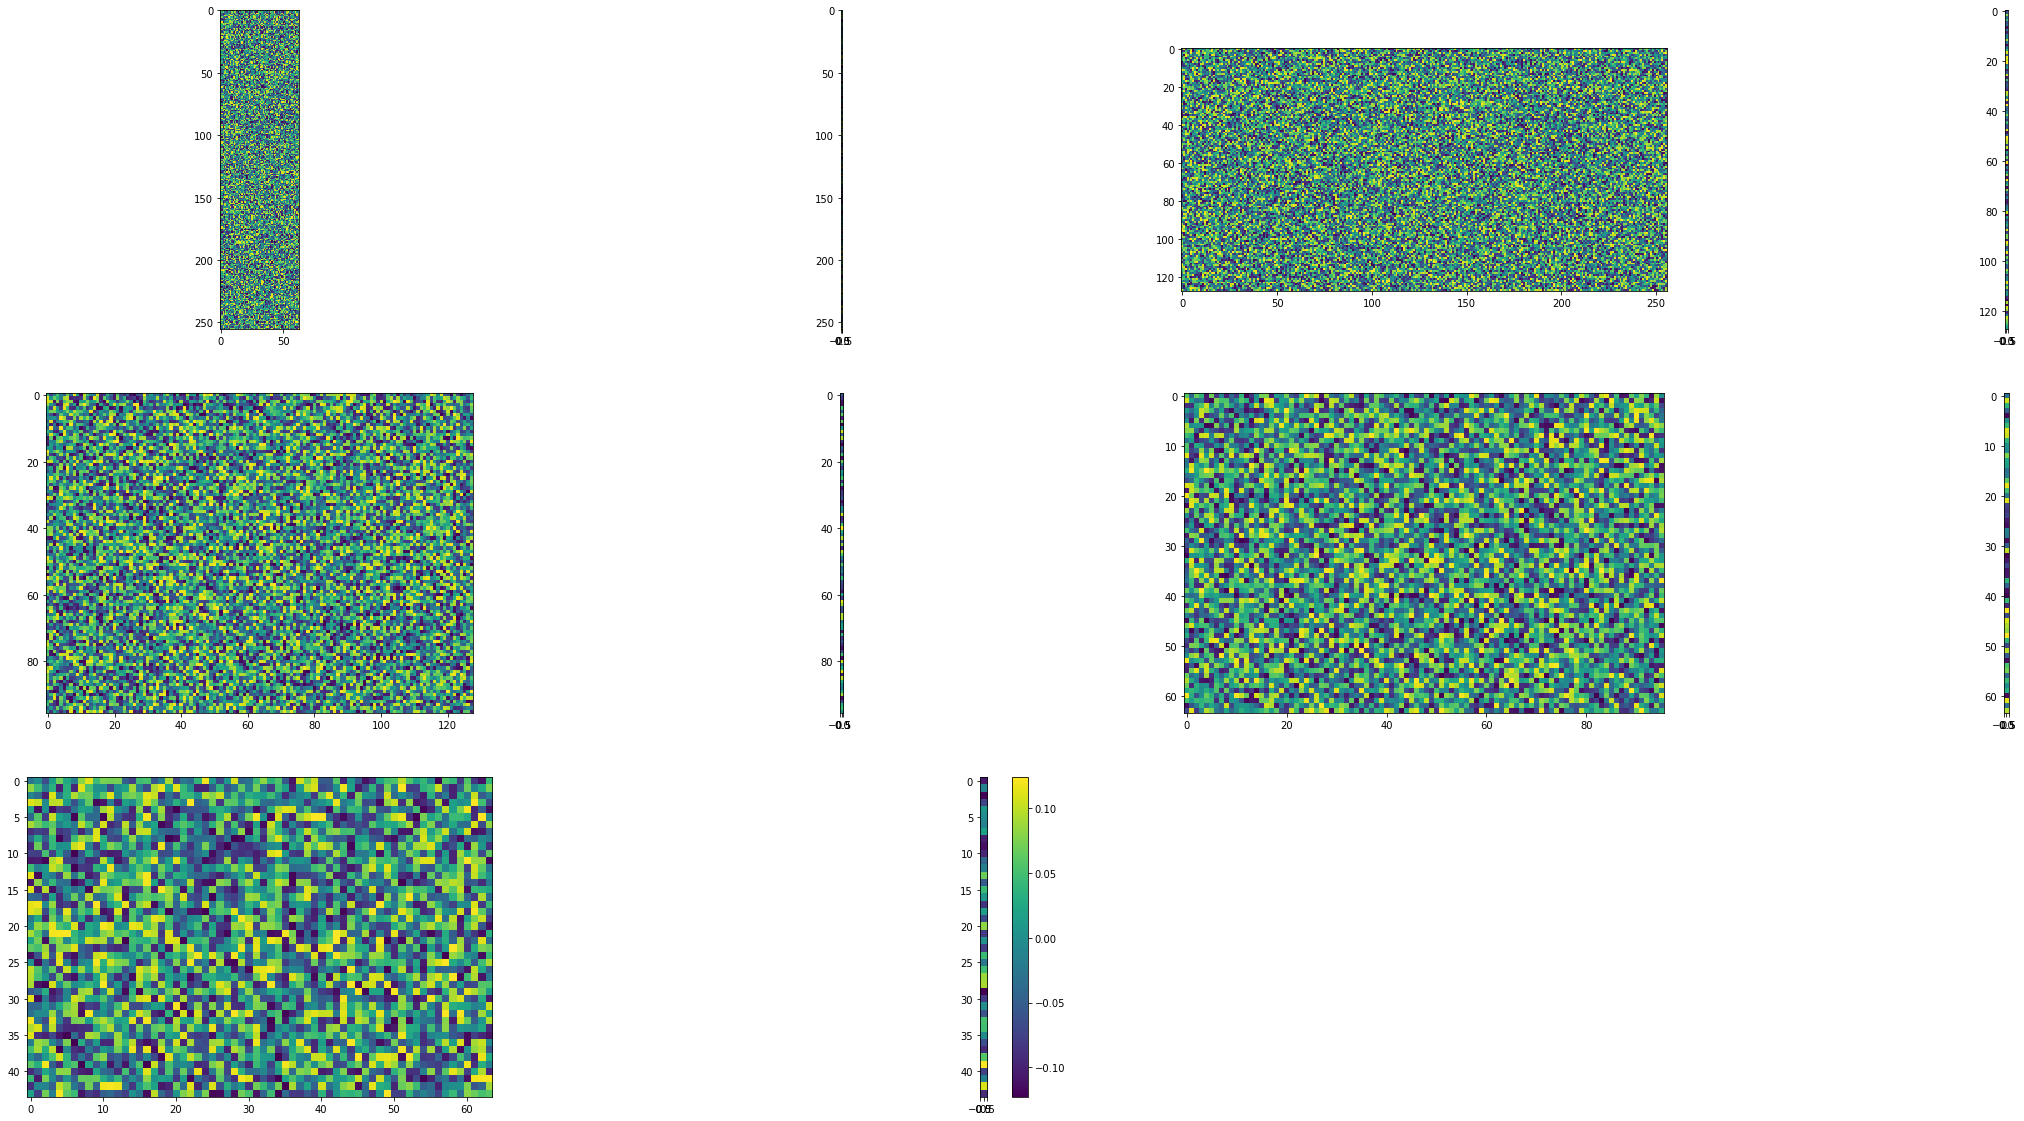

In [9]:
def draw_plot():
    w=40
    h=20
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 3
    for i, m in enumerate(policy_net.modules()):
        if isinstance(m, nn.Linear):
            fig.add_subplot(rows, columns, 2 * i - 1)
            plt.imshow(m._parameters['weight'].detach().numpy())
            fig.add_subplot(rows, columns, 2 * i)
            plt.imshow(m._parameters['bias'].detach().numpy().reshape(-1, 1))
    plt.colorbar()
    plt.show()

draw_plot()

50 19900 19655 30000 81.4 0.05 1.48 2.8 703105 131156


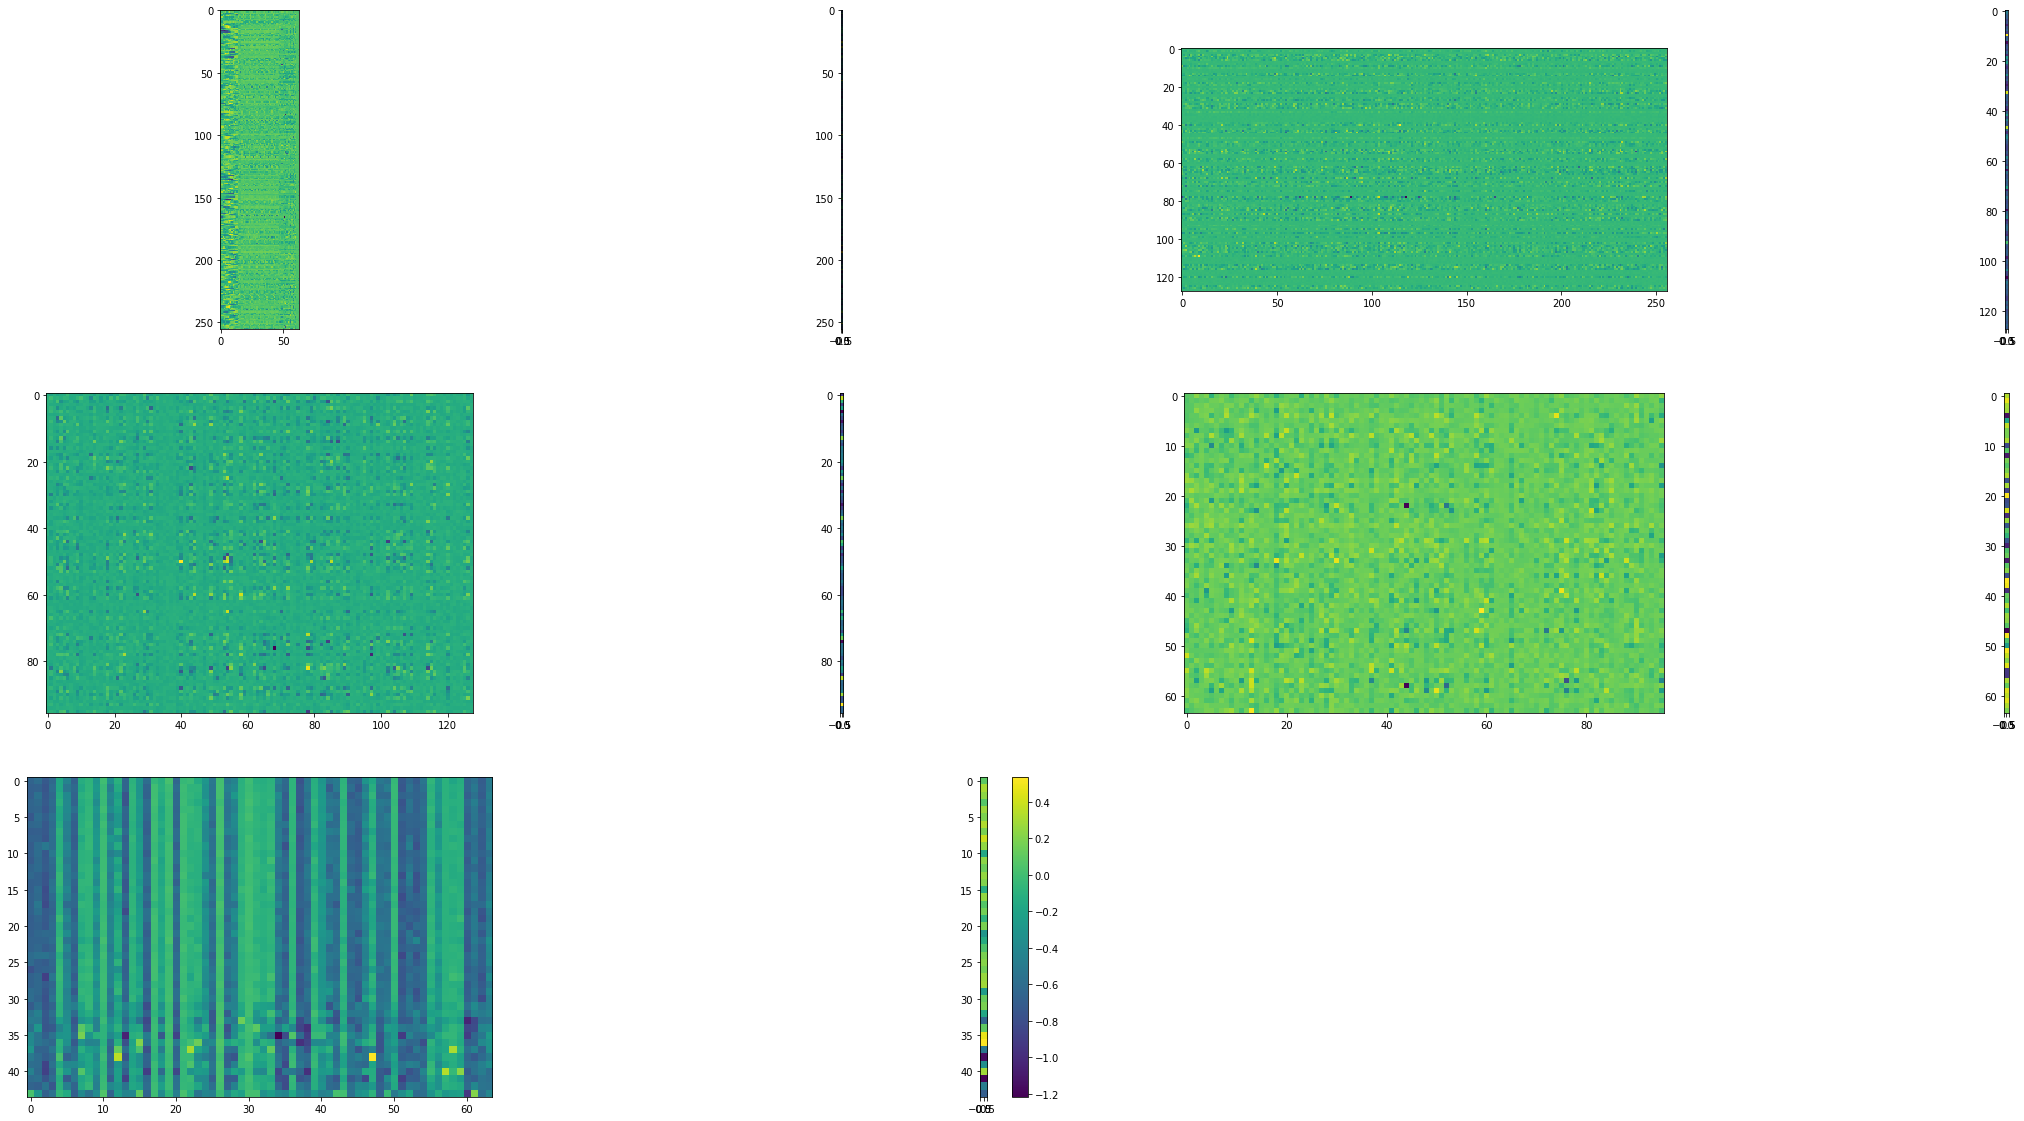

Complete


In [10]:
num_episodes = 20000
print_interval = 100
for i_episode in range(num_episodes):
    if i_episode % print_interval == 0 and i_episode > 0:
        clear_output()
        print(max_episode_length,
              i_episode,
              optimization_count,
              len(memory), 
              round(mean(episode_rewards[-print_interval:]), 1), 
              round(get_eps_threshold(), 3),
              mean(rewards_non_random[-100:]), 
              mean(rewards_random[-100:]),
              len(rewards_non_random), 
              len(rewards_random),
             )
        draw_plot()
    # Initialize the environment and state
    env.reset()
    state = env.get_observation_space()
    possible_actions = env.pyhtzee.get_possible_actions()
    state = transform_state(state, possible_actions)
    cum_reward = 0
    cum_valid = 0
    cum_invalid = 0
    for t in count():
        max_episode_length = max(max_episode_length, t)
#        if t % 10 == 0:
#            print(i_episode, t, env.pyhtzee.round, env.pyhtzee.sub_round, cum_reward, cum_valid, cum_invalid)
#            print(i_episode, t, env.pyhtzee.round, env.pyhtzee.sub_round, cum_reward, cum_valid, cum_invalid)
        # Select and perform an action
        action, action_type = select_action(state, possible_actions)
        next_state, reward, done, debug_info = env.step(action.item())
        if action_type == 1:
            rewards_non_random.append(reward)
        else:
            rewards_random.append(reward)
        
        next_possible_actions = env.pyhtzee.get_possible_actions()
        next_state = transform_state(next_state, next_possible_actions)
        cum_reward += reward
        
        reward = torch.tensor([reward], dtype=torch.float, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        possible_actions = next_possible_actions

        # Perform one step of the optimization (on the target network)
        if done:
            optimize_model()
            episode_rewards.append(cum_reward)
            episode_durations.append(t + 1)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

In [31]:
state = env.get_observation_space()
print(state)

transformed_state = transform_state(state, possible_actions)

nn_state = transformed_state[:, :63]
nn_mult = transformed_state[:, 63:]
print(policy_net(transformed_state))


max_action = policy_net(transformed_state).max(1)[1].view(1, 1)
possible_actions = env.pyhtzee.get_possible_actions()

print(max_action)
print(transformed_state)
print(possible_actions)
print(action)
print(nn_mult)
print(torch.max(nn_mult) + nn_state)
print(torch.max(nn_mult) + 1 + nn_state)

(12, 3, 5, 2, 6, 3, 1, 1, 0, 3, 0, 0, 12, 0, -1, 0, 0, 0, 21, 0, 0, -1)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0466,  0.0000,
          0.0000, -0.0000, -0.0000,  0.0000]], grad_fn=<MulBackward0>)
tensor([[43]])
tensor([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
          1.,  1.,  1.,  1.,  1.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.

In [14]:
# run one full simulation

env.reset()
state = env.get_observation_space()
cum_reward = 0

for i in range(100):
    print(f'State: {state}')
    possible_actions = env.pyhtzee.get_possible_actions()
    print(f'Possible actions: {possible_actions}')
    state = transform_state(state, possible_actions)
    action = policy_net(state).max(1)[1].view(1, 1)
    action = action.item()
    print(f'Action taken: {action}')
    state, reward, done, debug_info = env.step(action)
    cum_reward += reward
    print(f'Reward: {reward}')
    if done:
        print(f'Total Reward: {cum_reward}')
        break


State: (0, 1, 2, 1, 2, 4, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)
Possible actions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Action taken: 25
Reward: 0
State: (0, 2, 2, 1, 5, 6, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)
Possible actions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Action taken: 26
Reward: 0
State: (0, 3, 2, 1, 4, 6, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)
Possible actions: [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Action taken: 42
Reward: 0
State: (1, 0, 1, 5, 1, 2, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1)
Possible actions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28

In [11]:
#print(env.get_observation_space())

state, reward, done, debug_info = env.step(31)
print(state)
print(reward)
#env.pyhtzee.get_possible_actions()

(13, 0, 6, 5, 4, 5, 4, 1, 2, 0, 4, 5, 12, 15, 0, 0, 0, 0, 16, 0, 0, -1)
0
